EMI Selection parameters

In [1]:
# Do you want to select EMI at every time step, or only when EMI were selected in the original data?
EMI_at_every_timestep = False

# Do you want to allow the algorithm to select no EMI at all?
allow_no_EMI = False

# Do you want to exclude short time series?
exclude_short = False

# What is the weight of control energy in the loss function?
rho = 80

In [2]:
from ctrl import utils

# data = utils.generate_random_dataset(10, 50)
data = utils.load_data()

Apply the optimal control, brute force, and max AC strategies in their offline version to all time series. Calculate the predicted effects of their selected inputs.

In [3]:
import ctrl.discrete_optimal_control as doc
import ctrl.control_strategies as strategies
import numpy as np
import pandas as pd

n_inp = data[0]['Inp'].shape[1]
n_emas = data[0]['X'].shape[1]
Yref = np.ones(n_emas) * (-3)
Q = np.eye(n_emas)
R = np.eye(n_inp) * rho

if allow_no_EMI:
    select_from = np.vstack((np.eye(n_inp), np.zeros(n_inp)))
else:
    select_from = np.eye(n_inp)
effects = pd.DataFrame(index=range(len(data)))

for i, d in enumerate(data):
    
    A, B, lmbda = utils.stable_ridge_regression(d['X'], d['Inp'])
    if EMI_at_every_timestep:
        EMI_times = np.arange(len(d['Inp']))
    else:
        EMI_times = np.where(d['Inp'].sum(axis=1) > 0)[0]
    if EMI_times[-1] >= len(d['Inp'])-1:
        EMI_times = EMI_times[:-1]

    # Empirical effects
    effects.loc[i,'empirical'] = (d['X'][EMI_times + 1] - d['X'][EMI_times]).mean()

    # Rounded optimal control strategy
    U_opt = strategies.optimal_control_strategy(d['X'], d['Inp'], Yref, select_from, rho, online=False)
    X_ctrl_opt = doc.step(A, B, d['X'], U_opt)
    effects.loc[i,'optimal ctrl'] = (X_ctrl_opt[EMI_times] - d['X'][EMI_times]).mean()

    # 5-step brute force strategy
    U_bf = strategies.brute_force_strategy(d['X'], d['Inp'], Yref, select_from, 5, rho, online=False)
    X_ctrl_bf = doc.step(A, B, d['X'], U_bf)   
    effects.loc[i,'brute force'] = (X_ctrl_bf[EMI_times] - d['X'][EMI_times]).mean()

    # Largest AC strategy
    U_ac = strategies.max_ac_strategy(d['X'], d['Inp'], select_from, online=False)
    X_ctrl_ac = doc.step(A, B, d['X'], U_ac)
    effects.loc[i,'max AC'] = (X_ctrl_ac[EMI_times] - d['X'][EMI_times]).mean()

effects.index = np.arange(1,11)

Calculate the mean effects (and standard deviations) for each strategy

In [4]:
print('MEAN EFFECTS')
print(effects.mean())
print('STD EFFECTS')
print(effects.std())

MEAN EFFECTS
empirical      -0.104219
optimal ctrl   -0.377856
brute force    -0.390347
max AC         -0.334933
dtype: float64
STD EFFECTS
empirical       0.097329
optimal ctrl    0.347194
brute force     0.225026
max AC          0.477215
dtype: float64


Calculate the relative effects: the difference of the predicted and the observed effects

In [5]:
relative_effects = effects[['optimal ctrl', 'brute force', 'max AC']] - effects[['empirical']].to_numpy()

Test the relative effects against 0

In [6]:
from scipy.stats import ttest_1samp

print(ttest_1samp(relative_effects['optimal ctrl'], 0))
print(ttest_1samp(relative_effects['brute force'], 0))
print(ttest_1samp(relative_effects['max AC'], 0))

TtestResult(statistic=-2.1428301899241826, pvalue=0.06074100973757152, df=9)
TtestResult(statistic=-3.5935562468365987, pvalue=0.005806439196943078, df=9)
TtestResult(statistic=-1.3803429354848173, pvalue=0.2007966211018456, df=9)


Calculate the effect sizes for each strategy

In [7]:
print('HEDGES G')
print('optimal ctrl:', utils.cohens_d(effects['empirical'], effects['optimal ctrl'], correct=True))
print('brute force:', utils.cohens_d(effects['empirical'], effects['brute force'], correct=True))
print('max AC:', utils.cohens_d(effects['empirical'], effects['max AC'], correct=True))

HEDGES G
optimal ctrl: 1.027878668844013
brute force: 1.5807176602271076
max AC: 0.6416175628598989


Plot the relative effects of each strategy

C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_28952\801577151.py:10: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('figures/3b.png')
d:\ZI Mannheim\Control Theory\paper_EMIcompass\code\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


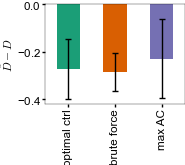

In [8]:
import matplotlib.pyplot as plt
from custom_rcparams_paper import colors

plt.subplots(layout='constrained')
ax = relative_effects.mean().plot(kind='bar', ylabel='$\hat{D} - D$', yerr=relative_effects.sem(), figsize=(1.7, 1.5),
                         color=colors.algorithms, ecolor=colors.errorbars)
ax.set_xticks(range(len(relative_effects.columns)), labels=relative_effects.columns)
utils.set_axis_size(ax, 1.4, 1)

plt.savefig('figures/3b.png')

Apply the optimal control, brute force, and max AC strategies in their online version to all time series. Calculate the predicted effects of their selected inputs.

In [23]:
from tqdm import tqdm

online_effects = []

if allow_no_EMI:
    select_from = np.vstack((np.eye(n_inp), np.zeros(n_inp)))
else:
    select_from = np.eye(n_inp)

for i, d in enumerate(data):

    if EMI_at_every_timestep:
        EMI_times = np.arange(len(d['Inp']))
    else:
        EMI_times = np.where(d['Inp'].sum(axis=1) > 0)[0]
    EMI_times = EMI_times[EMI_times>=20]
    if len(EMI_times)==0:
        continue
    if EMI_times[-1] >= len(d['Inp'])-1:
        EMI_times = EMI_times[:-1]
    subject_effects = pd.DataFrame(index=pd.MultiIndex.from_product([[i], EMI_times], names=['subject', 'timestep']))
    linalg_errors = []

    for t in tqdm(EMI_times, desc=f'Subject {i}; length {len(d["X"])}'):

        if exclude_short and len(d['X'])<25:
            continue

        subject_effects.loc[(i, t),'empirical'] = (d['X'][t+1] - d['X'][t]).mean()

        # Rounded optimal control strategy
        try:
            U_opt = strategies.optimal_control_strategy(d['X'][:t+1], d['Inp'][:t+1], Yref, select_from, rho, online=True)
        except np.linalg.LinAlgError:
            linalg_errors.append(t)
        else:
            X_ctrl_opt = doc.step(d['A'], d['B'], d['X'][t], U_opt)
            subject_effects.loc[(i,t),'optimal ctrl'] = (X_ctrl_opt - d['X'][t]).mean()

        # 5-step brute force strategy
        U_bf = strategies.brute_force_strategy(d['X'][:t+1], d['Inp'][:t+1], Yref, select_from, 5, rho, online=True)
        X_ctrl_bf = doc.step(d['A'], d['B'], d['X'][t], U_bf)   
        subject_effects.loc[(i,t),'brute force'] = (X_ctrl_bf - d['X'][t]).mean()

        # Largest AC strategy
        U_ac = strategies.max_ac_strategy(d['X'][:t+1], d['Inp'][:t+1], select_from, online=True)
        X_ctrl_ac = doc.step(d['A'], d['B'], d['X'][t], U_ac)
        subject_effects.loc[(i,t),'max AC'] = (X_ctrl_ac - d['X'][t]).mean()
    
    online_effects.append(subject_effects)
    if linalg_errors:
        print(f'Optimal control could not be calculated in subject {i} at times {linalg_errors} because the discrete algebraic riccati equation could not be solved.')

online_effects = pd.concat(online_effects, axis=0)

Subject 0; length 84: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
Subject 1; length 22: 0it [00:00, ?it/s]
Subject 8; length 40: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


Optimal control could not be calculated in subject 8 at times [29, 34] because the discrete algebraic riccati equation could not be solved.


Subject 9; length 88: 100%|██████████| 25/25 [00:01<00:00, 21.04it/s]


Calculate the mean effects per subject, then the mean and standard deviation over all subjects

In [24]:
print('MEAN EFFECTS')
print(online_effects.groupby('subject').mean().mean())
print('STD EFFECTS')
print(online_effects.groupby('subject').mean().std())

MEAN EFFECTS
empirical      -0.067864
optimal ctrl   -0.129579
brute force    -0.270369
max AC         -0.299083
dtype: float64
STD EFFECTS
empirical       0.154161
optimal ctrl    0.170630
brute force     0.138158
max AC          0.182697
dtype: float64


Calculate the relative effects by subtracting the predicted from the observed effects

In [25]:
relative_online_effects = online_effects[['optimal ctrl', 'brute force', 'max AC']] - online_effects[['empirical']].to_numpy()

Test the relative effects of the three strategies against zero

In [34]:
from scipy.stats import ttest_rel
print('optimal ctrl:', ttest_1samp(relative_online_effects.groupby('subject').mean()['optimal ctrl'], 0))

print('optimal ctrl:', ttest_rel(online_effects.groupby('subject').mean()['empirical'], online_effects.groupby('subject').mean()['optimal ctrl']))
print('brute force:', ttest_rel(online_effects.groupby('subject').mean()['empirical'], online_effects.groupby('subject').mean()['brute force']))
print('max AC:', ttest_rel(online_effects.groupby('subject').mean()['empirical'], online_effects.groupby('subject').mean()['max AC']))

optimal ctrl: TtestResult(statistic=-0.7586321813454547, pvalue=0.46983064207855096, df=8)
optimal ctrl: TtestResult(statistic=0.7221300232933927, pvalue=0.4907809893173828, df=8)
brute force: TtestResult(statistic=3.6686425543504835, pvalue=0.006321851843553447, df=8)
max AC: TtestResult(statistic=3.8554271791873744, pvalue=0.004840166409878514, df=8)


Calculate the effect size of the strategies

In [27]:
print('optimal ctrl:', utils.cohens_d(online_effects.groupby('subject').mean()['empirical'], online_effects.groupby('subject').mean()['optimal ctrl'], correct=True))
print('brute force:', utils.cohens_d(online_effects.groupby('subject').mean()['empirical'], online_effects.groupby('subject').mean()['brute force'], correct=True))
print('max AC:', utils.cohens_d(online_effects.groupby('subject').mean()['empirical'], online_effects.groupby('subject').mean()['max AC'], correct=True))

optimal ctrl: 0.36146784076361616
brute force: 1.3175586141134852
max AC: 1.3027648735904687


Plot the relative effects of the online effects

C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_28952\1979397565.py:6: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('figures/3c.png')
d:\ZI Mannheim\Control Theory\paper_EMIcompass\code\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
d:\ZI Mannheim\Control Theory\paper_EMIcompass\code\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


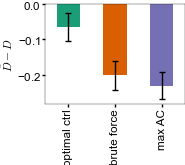

In [35]:
fig, ax = plt.subplots()
relative_online_effects.groupby('subject').mean().mean().plot(ax=ax, kind='bar', ylabel='$\hat{D} - D$',
                    yerr=online_effects.sem(), color=colors.algorithms)
utils.set_axis_size(ax, 1.4, 1)

fig.savefig('figures/3c.png')

Calculate the correlation of the online strategies' effects and the amount of data (time series length) that exists at the time of input selection. Exclude data points from before time 40.

In [38]:
from scipy.stats import pearsonr

print('CORRELATION EFFECTS * TIME SERIES LENGTH FOR T>=40')
ts_length = online_effects.dropna().index.get_level_values(1)
mask = ts_length>40
print(pearsonr(ts_length[mask], online_effects.dropna().loc[mask, 'optimal ctrl']))
print(pearsonr(ts_length[mask], online_effects.dropna().loc[mask, 'brute force']))
print(pearsonr(ts_length[mask], online_effects.dropna().loc[mask, 'max AC']))

CORRELATION EFFECTS * TIME SERIES LENGTH FOR T>=40
PearsonRResult(statistic=-0.29733180292483763, pvalue=0.02605183784194951)
PearsonRResult(statistic=-0.20541422983280136, pvalue=0.1288238457613038)
PearsonRResult(statistic=-0.00435656832003882, pvalue=0.9745785961697447)
